# Effect of Yesterday's Load on Performance and Wellness

After applying mixed models with random intercepts and GEE, one other interesting thing to explore owuld be to see if there is any specific relationship between yesterday's training load on the performance and wellness.<br><br>
In this notebook we will investigate this by first creating the proper dataset that includes yesterday's daily loads,  then merging it with wellness or performance data and then applying GEEs and random mixed models to find the best fit and compare their coefficients.


In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
import warnings


## Reading data

In [3]:
rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
rpe_df = rpe_df.drop(columns=['Unnamed: 0'])
print(rpe_df.head())

         Date  PlayerID  Training SessionType  Duration  RPE  SessionLoad  \
0  2017-08-01        15         1    Strength      60.0  4.0        240.0   
1  2017-08-01         1         1       Speed      60.0  3.0        180.0   
2  2017-08-01         1         1    Strength      90.0  4.0        360.0   
3  2017-08-01         3         1       Speed      45.0  5.0        225.0   
4  2017-08-01         3         1    Strength      90.0  5.0        450.0   

   DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0      300.0               4.29              6.0          7.0   
1      540.0               4.29              0.0          0.0   
2      540.0               4.29              0.0          0.0   
3      675.0               4.29              7.0          7.0   
4      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              2.0      42.86         10.0  
1              2.0      77.14         18.0  
2          

In [4]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
print(wellness_df.head())

         Date  PlayerID  MonitoringScore  Fatigue  Soreness  Desire  \
0  2018-07-21         1               13        3         3       2   
1  2018-07-21         2               19        4         3       4   
2  2018-07-21         3               19        3         3       5   
3  2018-07-21         4               15        2         3       5   
4  2018-07-21         5               20        5         3       4   

   Irritability  SleepScore  SleepHours  SleepQuality  TrainingReadiness  \
0             3        16.0        8.00             2                  0   
1             4        32.0        8.00             4                  0   
2             4        32.0        8.00             4                100   
3             4         6.5        6.50             1                 95   
4             4        29.0        7.25             4                100   

   Pain  Illness  Nutrition  StandardizedMonitoringScore  StandardizedPain  \
0     1        3          3           

In [32]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
print(gps_df.head())

        Date  GameID Outcome  TeamPoints  PlayerID  MaxSpeedInGame  \
0 2017-11-30       1       W          19         2        7.284728   
1 2017-11-30       1       W          19         3        6.852436   
2 2017-11-30       1       W          19         4        7.267784   
3 2017-11-30       1       W          19         6        6.338894   
4 2017-11-30       1       W          19         7        7.065283   

   MaxAccelImpulseInGame  
0               4.423615  
1               4.888893  
2               5.694449  
3               4.777782  
4               4.091273  


## Create yesterday's dataset

To do this we can just shift the dates by 1 day and then merge iy with the wellness or performance data. This way for ech day in the new merged datsets we will basically have yesterday's training load.

In [12]:
yesterday_rpe = rpe_df.copy()[['Date','PlayerID','Training','SessionLoad','RPE','DailyLoad']]
yesterday_rpe['Date'] = pd.to_datetime(yesterday_rpe['Date'], format='%Y-%m-%d')

# Add one day to all dates
yesterday_rpe['Date'] = pd.DatetimeIndex(yesterday_rpe['Date']) + pd.DateOffset(1)
yesterday_rpe = yesterday_rpe.rename(columns = {'DailyLoad':'YesterdayLoad'})

yesterday_rpe.head()

Index(['Date', 'PlayerID', 'Training', 'SessionType', 'Duration', 'RPE',
       'SessionLoad', 'DailyLoad', 'AcuteChronicRatio', 'ObjectiveRating',
       'FocusRating', 'BestOutOfMyself', 'AcuteLoad', 'ChronicLoad'],
      dtype='object')
         Date  PlayerID  MonitoringScore  Fatigue  Soreness  Desire  \
0  2018-07-21         1               13        3         3       2   
1  2018-07-21         2               19        4         3       4   
2  2018-07-21         3               19        3         3       5   
3  2018-07-21         4               15        2         3       5   
4  2018-07-21         5               20        5         3       4   

   Irritability  SleepScore  SleepHours  SleepQuality  TrainingReadiness  \
0             3        16.0        8.00             2                  0   
1             4        32.0        8.00             4                  0   
2             4        32.0        8.00             4                100   
3             4         6.5  

# Training load on the day before and today's wellness

To do this we first need to merge the data with wellness data:

In [13]:
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'],format='%Y-%m-%d')

# Merge yesterday training load with wellness data
wellness_with_yesterday_training = yesterday_rpe.merge(wellness_df,
    how='inner', on= ['Date','PlayerID'])[['Date','PlayerID','YesterdayLoad',
                                           'MonitoringScore','TrainingReadiness',
                                           'Pain','Illness','Nutrition',
                                           'wellness']].drop_duplicates()


In [14]:
# Sanity check
wellness_with_yesterday_training[(wellness_with_yesterday_training['PlayerID'] == 1)]

           Date  PlayerID  YesterdayLoad  MonitoringScore  TrainingReadiness  \
315  2017-08-17         1            0.0               19                 80   
346  2017-08-18         1          510.0               20                 85   
378  2017-08-19         1         1230.0               21                  0   
408  2017-08-20         1            0.0               20                100   
454  2017-08-22         1          670.0               17                 85   
493  2017-08-23         1         1080.0               17                 70   
520  2017-08-24         1            0.0               16                 85   
586  2017-08-26         1         1020.0               17                  0   
610  2017-08-27         1            0.0               18                  0   
620  2017-08-28         1            0.0               20                 75   
651  2017-08-29         1          780.0               20                 70   
688  2017-08-30         1          630.0

In [16]:
processed_wellness = wellness_with_yesterday_training.copy()

# Since wellness values are really small we need to rescale training loads as well
processed_wellness['YesterdayLoad'] = StandardScaler().fit_transform(wellness_with_yesterday_training[['YesterdayLoad']])

processed_wellness[(processed_wellness['PlayerID'] == 2)]

           Date  PlayerID  YesterdayLoad  MonitoringScore  TrainingReadiness  \
316  2017-08-17         2           40.0               18                 80   
343  2017-08-18         2          870.0               19                 75   
385  2017-08-19         2         1170.0               22                  0   
409  2017-08-20         2            0.0               23                  0   
423  2017-08-21         2            0.0               20                 85   
450  2017-08-22         2          570.0               23                 90   
488  2017-08-23         2          840.0               18                 65   
517  2017-08-24         2           45.0               19                 75   
550  2017-08-25         2          720.0               22                 90   
581  2017-08-26         2          900.0               22                  0   
611  2017-08-27         2            0.0               27                  0   
621  2017-08-28         2            0.0

Before applying any model, it is again a good idea to visualize yesterday's load vs wellness over all days for each players to see if we can observe any obvious relationship or pattern.

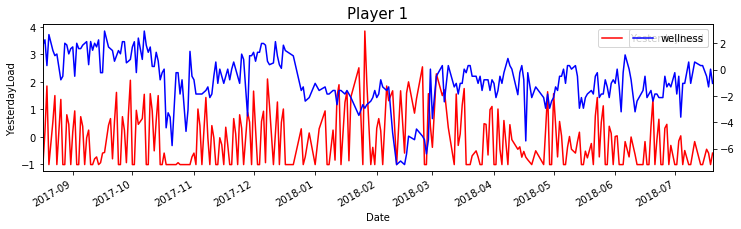

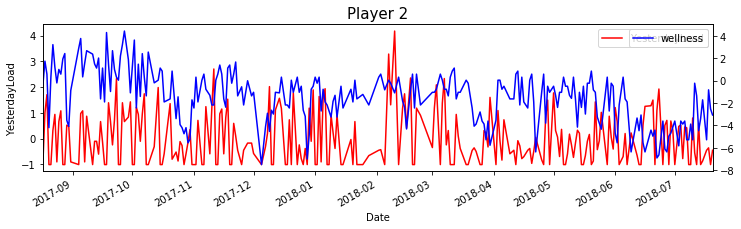

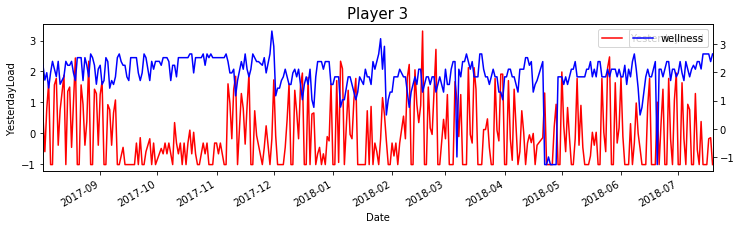

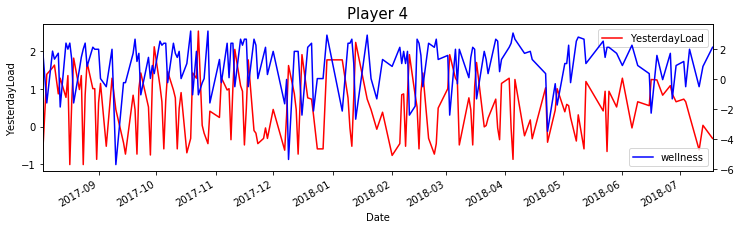

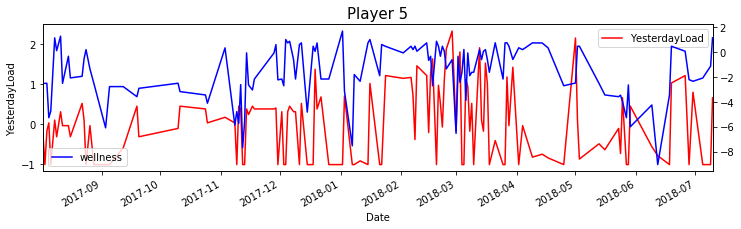

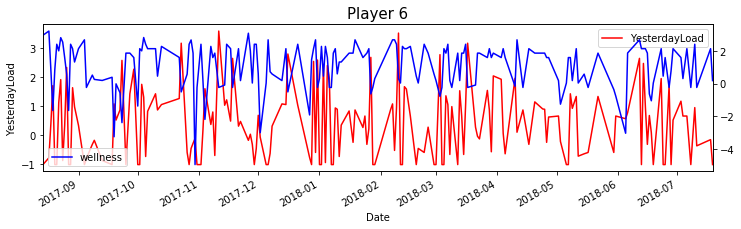

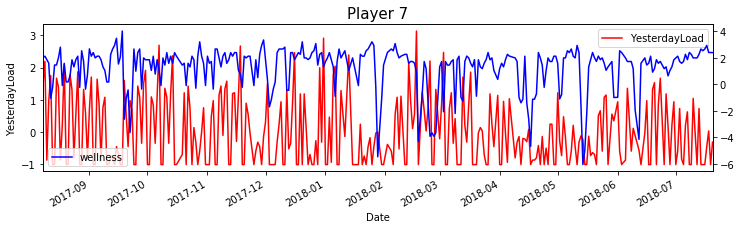

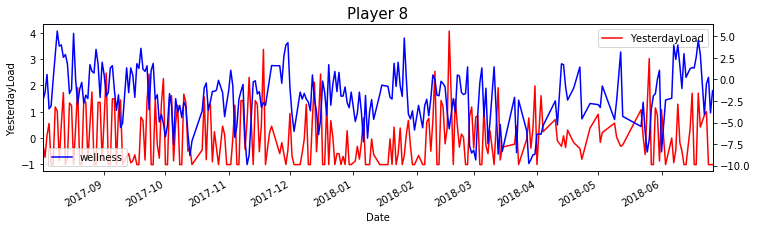

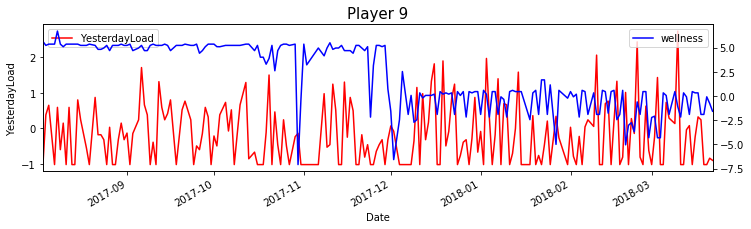

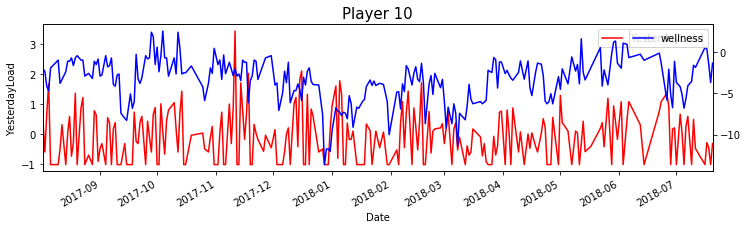

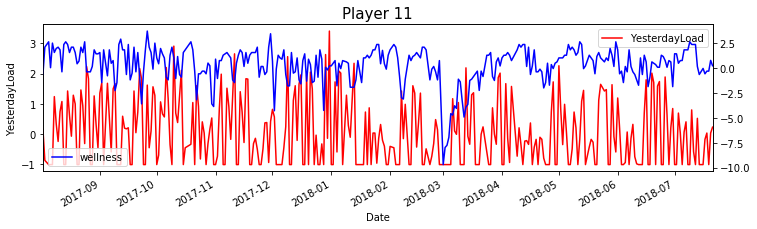

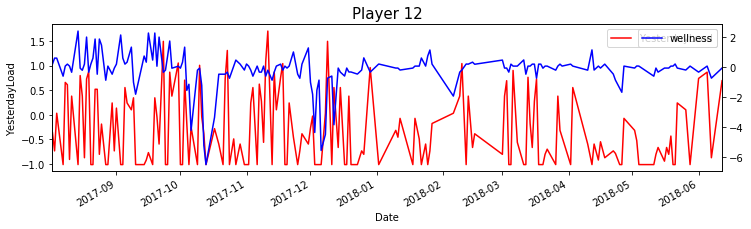

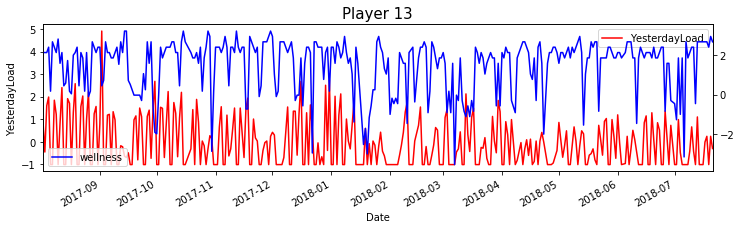

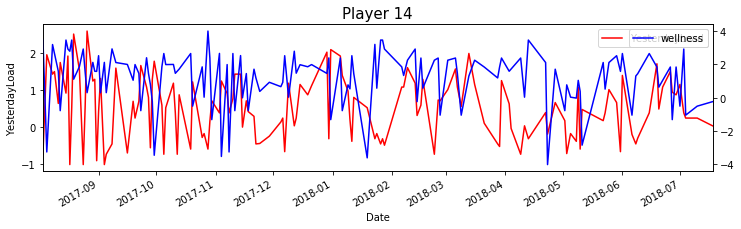

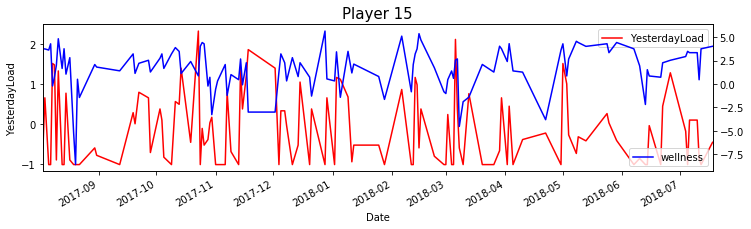

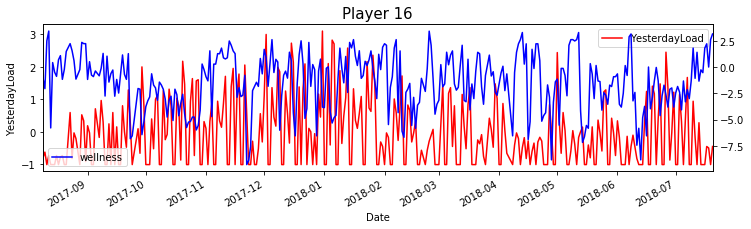

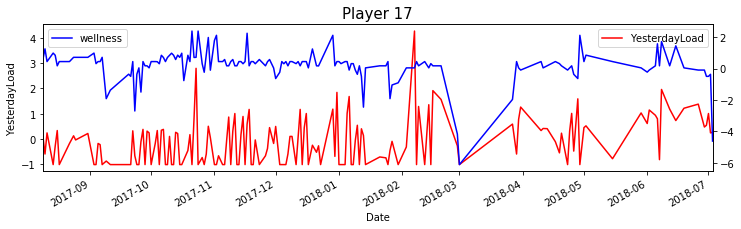

In [17]:
grouped = processed_wellness.groupby(['PlayerID'])

for name,group in grouped:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(111)

    group.plot.line(ax=ax1, color='red',x="Date",y="YesterdayLoad")
    ax1.set_ylabel('YesterdayLoad')
    ax3 = ax1.twinx()
    group.plot.line(ax=ax3, color='blue',x="Date",y="wellness")

    ax1.set_title('Player ' + str(name), fontsize=15)

plt.show()
plt.close()

Just based on the graphs it is hard to see any specific pattern, so let's invetigate this further by applying GEEs and random intercept mixed models.

In [18]:
# Helper function to draw scatter plots given the dataframe and appropriate columns
def scatter_plot(df, x, y, title=None):
    df.plot.scatter(x, y)
    if title:
        plt.title(title)
    plt.show()
    

# Helper function to remove the outliers based on the IQR rule
def removeOutliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    new_df = df[(df[column_name] > Q1 - (1.5 * IQR)) & 
                (df[column_name] < Q3 + (1.5 * IQR))]
    return new_df    

                               GEE Regression Results                              
Dep. Variable:                    wellness   No. Observations:                 3928
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                 120
                      Estimating Equations   Max. cluster size:                 343
Family:                           Gaussian   Mean cluster size:               231.1
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Mon, 09 Dec 2019   Scale:                           5.049
Covariance type:                    robust   Time:                         22:20:38
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2495      0.328      0.761      0.447      -0.393       0.89

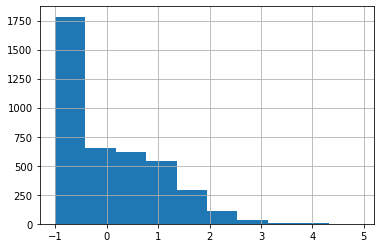

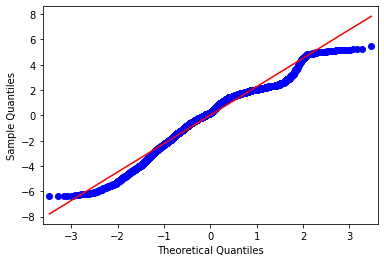

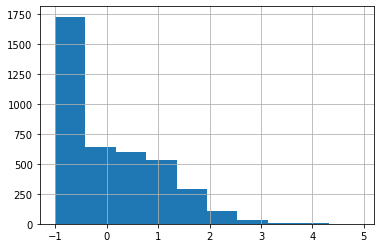

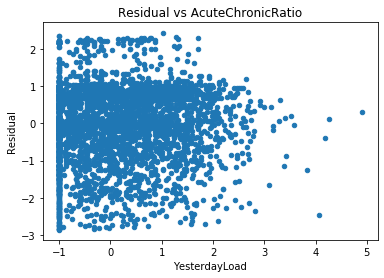

In [19]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()

processed_wellness = removeOutliers(processed_wellness, 'wellness')


mod = smf.gee("wellness ~ YesterdayLoad", "PlayerID", processed_wellness, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())
qqplot(res.resid, line='s')
plt.show()

processed_wellness['Residual'] = (res.resid - res.resid.mean()) / res.resid.std()
processed_wellness['YesterdayLoad'].hist()

scatter_plot(processed_wellness, 'YesterdayLoad', 'Residual', 'Residual vs AcuteChronicRatio')

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: wellness  
No. Observations: 3911    Method:             REML      
No. Groups:       17      Scale:              3.2630    
Min. group size:  119     Likelihood:         -7905.1759
Max. group size:  342     Converged:          Yes       
Mean group size:  230.1                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.245    0.337  0.729 0.466 -0.415  0.905
YesterdayLoad -0.107    0.029 -3.640 0.000 -0.165 -0.049
Group Var      1.912    0.378                           



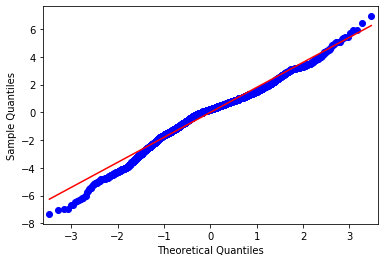

In [20]:
processed_wellness = processed_wellness.dropna()

mixed = smf.mixedlm("wellness ~ YesterdayLoad", processed, groups = processed["PlayerID"])
mixed_fit = mixed.fit()
print(mixed_fit.summary())
qqplot(mixed_fit.resid, line='s')
plt.show()

From the qqplots, we can see that the random mixed model is a better fit compared to the gee model. Even though the coefficients in both models are similiar.

In [21]:
processed_wellness['wellness'].std()

2.2462624414912304

In [22]:
processed_wellness['wellness'].quantile(0.25)

-1.0484484580700242

In [23]:
processed_wellness['wellness'].median()

0.4501752655233835

In [24]:
processed_wellness['wellness'].quantile(0.75)

1.9832673880574283

In [25]:
processed_wellness['YesterdayLoad'].std()

1.0006629773212115

In [26]:
processed_wellness['YesterdayLoad'].quantile(0.25)

-1.0128931791732334

In [27]:
processed_wellness['YesterdayLoad'].quantile(0.4)

-0.559982470183608

In [28]:
processed_wellness['YesterdayLoad'].median()

-0.21855747417604443

In [29]:
processed_wellness['YesterdayLoad'].quantile(0.60)

0.148416331056575

In [30]:
processed_wellness['YesterdayLoad'].quantile(0.75)

0.7290710861714792

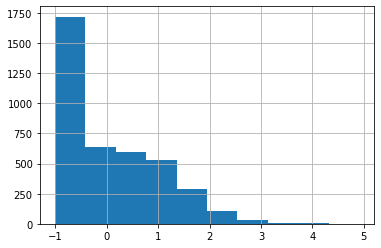

In [31]:
processed_wellness['YesterdayLoad'].hist()

# Performance vs yesterday's daily load

In [33]:
gps_df['Date'] = pd.to_datetime(gps_df['Date'],format='%Y-%m-%d')
speed_vs_yesterday_load = gps_df.merge(yesterday_rpe,
    how='inner', on= ['Date','PlayerID'])[['Date','PlayerID','YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']].drop_duplicates()

processed_speed = speed_vs_yesterday_load.copy()
processed_speed = processed_speed[(processed_speed['MaxSpeedInGame'] >= 5) & (processed_speed['MaxSpeedInGame'] <= 9)]
processed_speed[['YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']] = StandardScaler().fit_transform(processed_speed[['YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']])


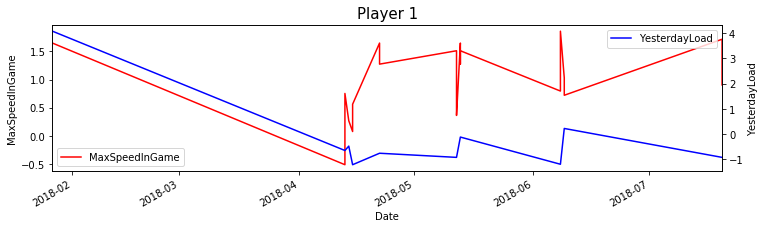

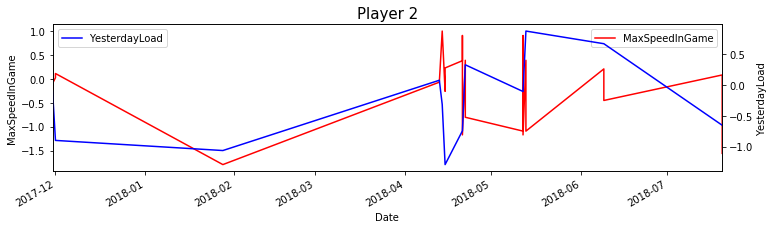

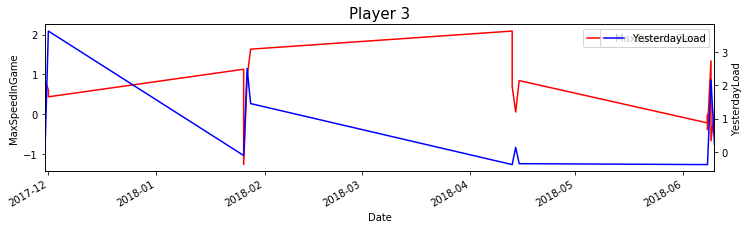

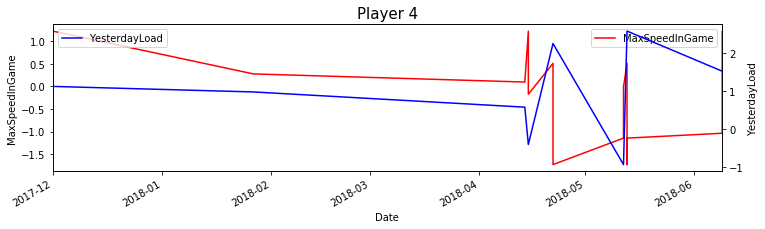

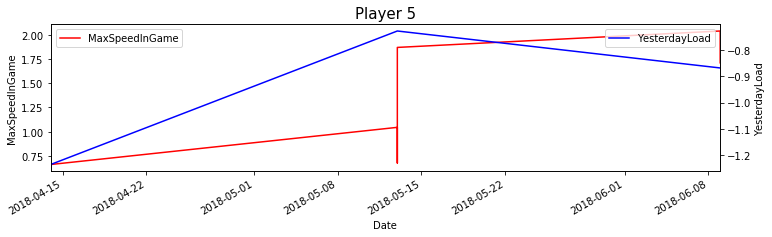

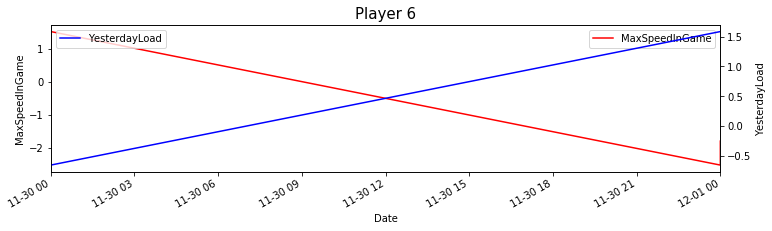

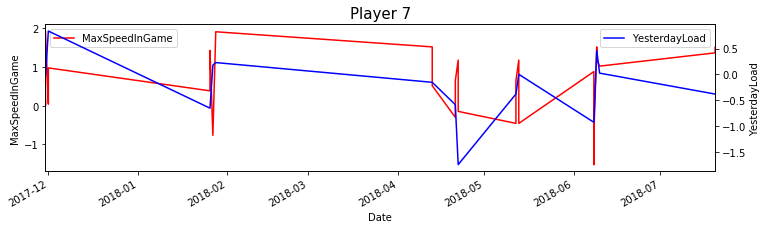

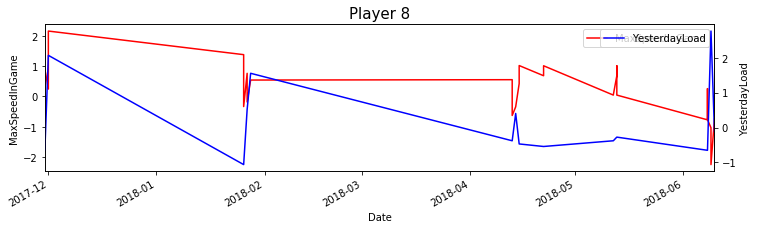

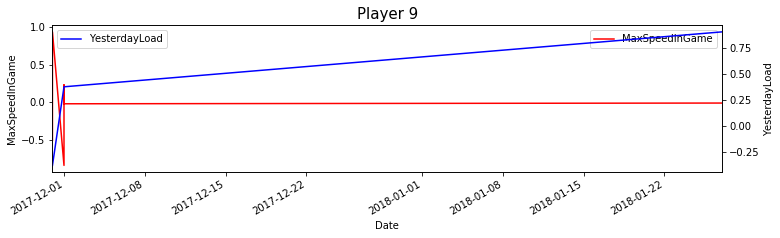

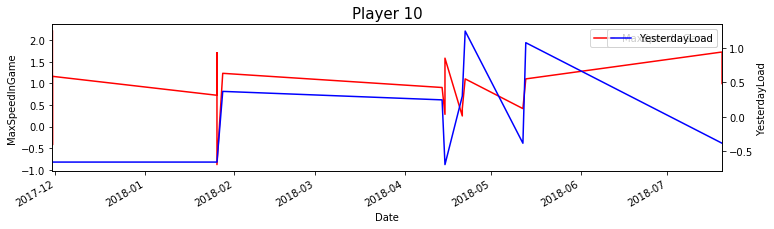

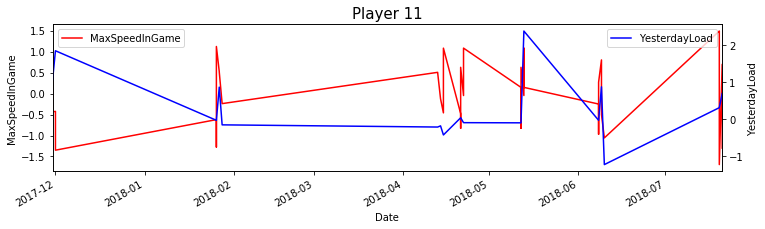

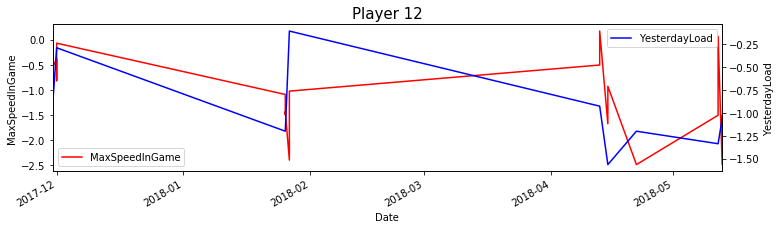

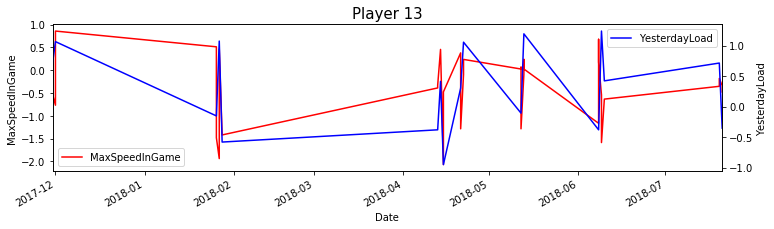

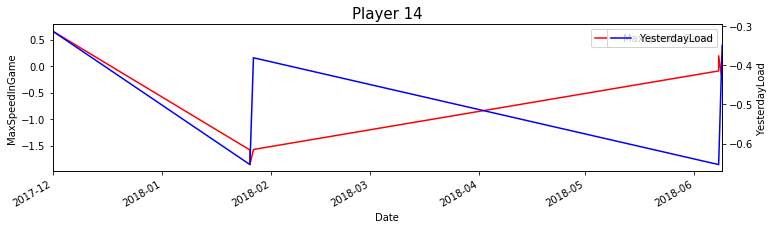

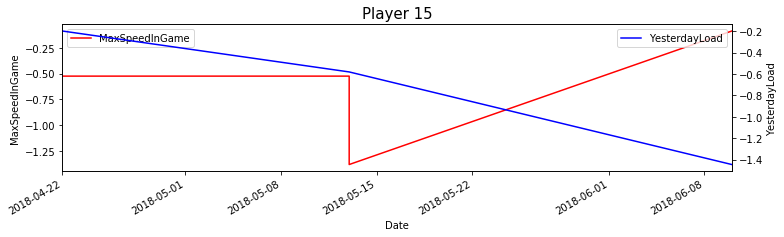

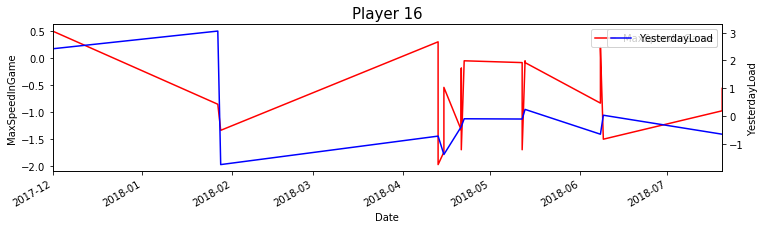

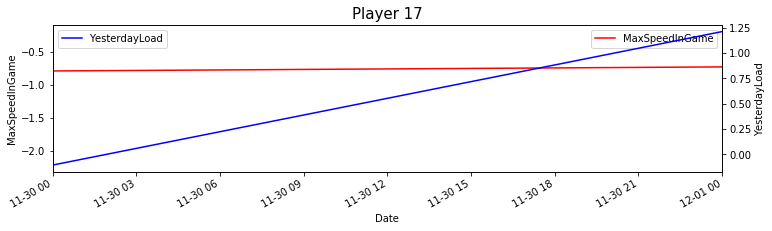

In [34]:
grouped = processed_speed.groupby(['PlayerID'])

for name,group in grouped:
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(111)
    group.plot.line(ax=ax1, color='red',x="Date",y="MaxSpeedInGame")
    ax1.set_ylabel('MaxSpeedInGame')
    ax3 = ax1.twinx()
    group.plot.line(ax=ax3, color='blue',x="Date",y="YesterdayLoad")
    ax3.set_ylabel('YesterdayLoad')
    ax1.set_title('Player ' + str(name), fontsize=15)

plt.show()
plt.close()

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  311
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                18.3
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Mon, 09 Dec 2019   Scale:                           1.007
Covariance type:                    robust   Time:                         22:20:43
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0324      0.160     -0.202      0.840      -0.347       0.28

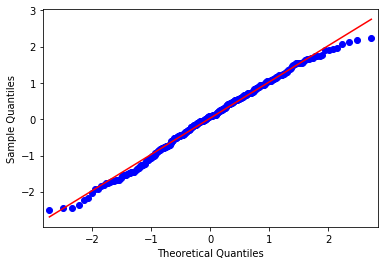

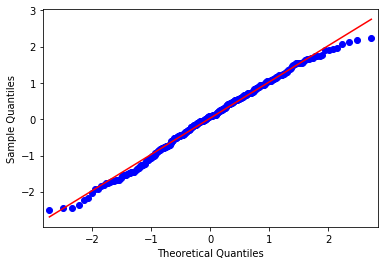

In [35]:
mod = smf.gee("MaxSpeedInGame ~ YesterdayLoad", "PlayerID", processed_speed, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())
qqplot(res.resid, line='s')

443 311
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 311     Method:             REML          
No. Groups:       17      Scale:              0.6858        
Min. group size:  4       Likelihood:         -404.0981     
Max. group size:  38      Converged:          Yes           
Mean group size:  18.3                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -0.043    0.168 -0.253 0.800 -0.372  0.287
YesterdayLoad      0.009    0.053  0.171 0.864 -0.095  0.113
Group Var          0.419    0.214                           



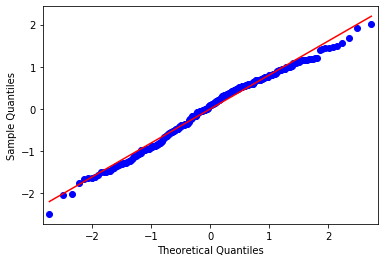

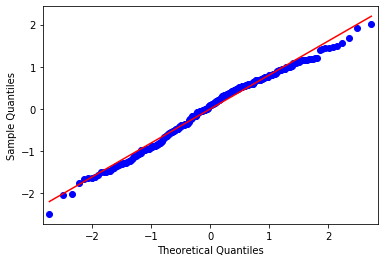

In [36]:
print(len(gps_df),len(processed_speed))
mixed = smf.mixedlm("MaxSpeedInGame ~ YesterdayLoad", processed_speed, groups = processed_speed["PlayerID"])
mixed_fit = mixed.fit()
print(mixed_fit.summary())
qqplot(mixed_fit.resid, line='s')

Previous day's daily load negativel affects today's performance as well as wellness.

In [37]:
print(processed_speed['MaxSpeedInGame'].std())
print(processed_speed['YesterdayLoad'].std())
print(processed_speed['MaxSpeedInGame'].median())
print(processed_speed['YesterdayLoad'].median())
print(processed_speed['MaxSpeedInGame'].quantile(0.75))
print(processed_speed['YesterdayLoad'].quantile(0.75))

1.0016116045911267
1.0016116045911272
0.05367714841573852
-0.16181075467338885
0.6842073603198825
0.37567395522922015
